In [1]:
#Activation of the libraries
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import openseespy.opensees as ops
import opsvis as opsv
import time

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 0.0611957 (max: 1e-06)
	Norm deltaX: 0.0264464, Norm R: 4.6279
	deltaX: 0 -0.0264464 
	deltaR: 0 -4.6279 
CTestEnergyIncr::test() - iteration: 2 current EnergyIncr: 0.00337782 (max: 1e-06)
	Norm deltaX: 0.00603557, Norm R: 1.11931
	deltaX: 0 -0.00603557 
	deltaR: 0 -1.11931 
CTestEnergyIncr::test() - iteration: 3 current EnergyIncr: 0.000196755 (max: 1e-06)
	Norm deltaX: 0.00144741, Norm R: 0.271871
	deltaX: 0 -0.00144741 
	deltaR: 0 -0.271871 
CTestEnergyIncr::test() - iteration: 4 current EnergyIncr: 1.1595e-05 (max: 1e-06)
	Norm deltaX: 0.000350839, Norm R: 0.066099
	deltaX: 0 -0.000350839 
	deltaR: 0 -0.066099 
CTestEnergyIncr::test() - iteration: 5 current EnergyIncr: 6.85197e-07 (max: 1e-06)
	Norm deltaX: 8.5255e-05, Norm R: 0.0160741
	deltaX: 0 -8.5255e-05 
	deltaR: 0 -0.0160741 

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 0.139501 (max: 1e-06)
	Norm deltaX: 0.0282047, Norm R: 9.89206
	deltaX: 0 -0.028204

[[0.00000000e+00 0.00000000e+00]
 [2.62643112e-01 1.04943686e+02]
 [6.07566949e-01 1.78826135e+02]
 [1.00421516e+00 2.13419325e+02]
 [1.40044772e+00 2.48537783e+02]
 [1.74367588e+00 3.23292514e+02]
 [2.00479779e+00 4.28657145e+02]
 [2.20770223e+00 5.47414502e+02]
 [2.37453574e+00 6.72255104e+02]
 [2.51773399e+00 8.00315098e+02]
 [2.51773399e+00 8.00315098e+02]
 [2.51773399e+00 8.00315098e+02]
 [2.51773399e+00 8.00315098e+02]
 [2.51773399e+00 8.00315098e+02]
 [2.51773399e+00 8.00315098e+02]
 [2.51773399e+00 8.00315098e+02]
 [2.51773399e+00 8.00315098e+02]
 [2.51773399e+00 8.00315098e+02]
 [2.51773399e+00 8.00315098e+02]
 [2.51773399e+00 8.00315098e+02]
 [2.51773399e+00 8.00315098e+02]
 [2.51773399e+00 8.00315098e+02]
 [2.51773399e+00 8.00315098e+02]
 [2.51773399e+00 8.00315098e+02]
 [2.51773399e+00 8.00315098e+02]
 [2.51773399e+00 8.00315098e+02]
 [2.51773399e+00 8.00315098e+02]
 [2.51773399e+00 8.00315098e+02]
 [2.51773399e+00 8.00315098e+02]
 [2.51773399e+00 8.00315098e+02]
 [2.517733

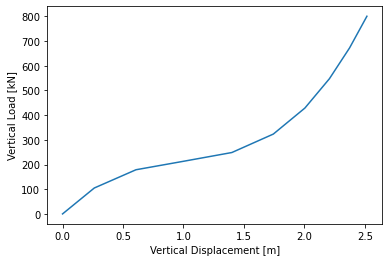

Running Time:  6.438223838806152  seconds


In [2]:
# Define the model
ops.wipe()
start = time.time()
### model('basic', '-ndm', ndm, '-ndf', ndf=ndm*(ndm+1)/2)
ops.model('basic', '-ndm', 2, '-ndf', 2)


ArcLengthAlpha = 0.41 #Initial value of alpha (arc length parameter)
ArcLengthLambda = 0.06  #Initial value of lambda (arc length parameter)
spring_stiffness = 213.131


#Geometric and material properties
E1 = 800000  # Modulus of elasticity in kN/m^2
A1 = 0.01  # Area of the section in m^2
E2 = 800000  # Modulus of elasticity in kN/m^2
A2 = 0.01 # Area of the section in m^2

# Load parameters
Px = 0
Py = 20 #kN

#Coordinates of the nodes
Lhalf = 3.7
L = 2*Lhalf
### node(nodeTag, *crds, '-ndf', ndf, '-mass', *mass, '-disp', *disp, '-vel', *vel, '-accel', *accel)
ops.node(1, 0.0, 0.0)
ops.node(2, Lhalf, 1.0) 
ops.node(3, Lhalf, 1.0)
ops.node(4, L, 0.0)


# Define boundary conditions (first and third nodes are free restrained)
### fix(nodeTag, *constrValues)
ops.fix(1, 1, 1)
ops.fix(3, 1, 1)
ops.fix(4, 1, 1)

# Define material
### uniaxialMaterial(matType, matTag, *matArgs)
ops.uniaxialMaterial('Elastic', 1, E1)
ops.uniaxialMaterial('Elastic', 2, E2)

# Spring stiffness in kN/m
 
ops.uniaxialMaterial('Elastic', 3, spring_stiffness)

# Define elements using corotTruss element (accounts for geometric nonlinearity)
### element(eleType, eleTag, *eleNodes, *eleArgs)
ops.element('corotTruss', 1, 1, 2, A1, 1)
ops.element('corotTruss', 2, 2, 4, A2, 2)
ops.element('zeroLength', 3, 3, 2, '-mat', 3, '-dir', 2)

# Define load at the middle node
### timeSeries(tsType, tsTag, *tsArgs)
ops.timeSeries('Linear', 1)
### pattern(patternType, patternTag, *patternArgs)
ops.pattern('Plain', 1, 1)

#Load
###load(nodeTag, *loadValues)
ops.load(2, 0, -Py)

# create SOE - System Of Equation
### system(systemType, *systemArgs)
ops.system('ProfileSPD')

# create DOF number
### numberer(numbererType, *numbererArgs)
ops.numberer('RCM')

# create constraint handler
### constraints(constraintType, *constraintArgs)
ops.constraints('Plain')

# create integrator
Nsteps=100 #Number of increments

ops.integrator('ArcLength', ArcLengthAlpha, ArcLengthLambda) 

# create algorithm
### algorithm(algoType, *algoArgs)
ops.algorithm('ModifiedNewton', '-initial') #MODIFIED NEWTON-RAPHSON!

# create test
### test(testType, *testArgs)
ops.test('EnergyIncr', 1.0e-6, 50, 4)

# create analysis object
### analysis(analysisType)
ops.analysis("Static")

#PERFORM ANALYSIS
data = np.zeros((Nsteps+1,2)) 
for j in range(Nsteps):
    ### analyze(numIncr=1, dt=0.0, dtMin=0.0, dtMax=0.0, Jd=0)
    ops.analyze(1) 
    data[j+1,0] = abs(ops.nodeDisp(2,2)) 
    data[j+1,1] = ops.getLoadFactor(1)*Py 
print(data)
results = pd.DataFrame(data, columns=['Displacement','Force'])
results.to_excel('Results - Arclength Method - RIKS AND WAMPNER.xlsx')

plt.plot(data[:,0], data[:,1])
plt.xlabel('Vertical Displacement [m]')
#plt.ylim(-30, 100)
plt.ylabel('Vertical Load [kN]')
plt.show()

end = time.time()
running_time = (end - start)
print('Running Time: ', running_time, ' seconds')